## Part 3: Logistic Regression

This is part 3 of my Binary Classification Comparison series predicting history of high blood pressure using the <a href="https://www.cdc.gov/brfss/annual_data/annual_2017.html" target="_blank">2017 CDC Behavioral Risk Factor Surveillance System dataset</a>. As I've mentioned previously, given that n >> p, overfitting is not a much of a concern for this dataset. Even so, I'll go through all the usual motions of building the model. Given that the SVM in the previous post used a linear kernel, I also expect performance to be VERY similar with this logistic regression. One possible advantage of logistic regression (assuming similar peformance) is that unlike the hinge loss used in SVM, logistic regression uses a loss function that can eventually give us predictions as probabilities. That carries some advantages when it comes to ensembling or specifying thresholds for predictions. Anyway, let's get on with it.

First, read in the data and the variables we chose in part 1:

In [1]:
# Import train/val
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

x_train = pickle.load( open( "x_train.pickle", "rb" ) )
x_val = pickle.load( open( "x_val.pickle", "rb" ) )
y_train = pickle.load( open( "y_train.pickle", "rb" ) )
y_val = pickle.load( open( "y_val.pickle", "rb" ) )
# Variables (selected previously)
keep_vars10 = pickle.load( open( "keep_vars10.pickle", "rb" ) )

## Regularization (L2)

I don't expect regularization to make much of a difference given the nature of the dataset (and if I wasn't treating this as just an exercise, I might not bother at all), but I'll still try out a few values of C to see if it affects peformance. Sklearn's LogisticRegression uses L2 norm (also known as ridge) regularization. It's important to note that C is the _inverse_ of regularization strength, so lower=more regularziation. The default value for sklearn is 1.0. We'll try a few values. Sklearn also has LogsiticRegressionCV, which is convenient for built-in cross-validation, but since I'm using a dedicated validation set for this series, I'll just code it myself.

In [2]:
# Possible C values
c_vals = [10**float(i) for i in np.arange(-5,1)]

# Train and save models by C
m_list = []
for i in c_vals:
    loopfit = LogisticRegression(C=i,
                                 solver='saga').fit(x_train[keep_vars10],
                                                    y_train)
    m_list.append(loopfit)

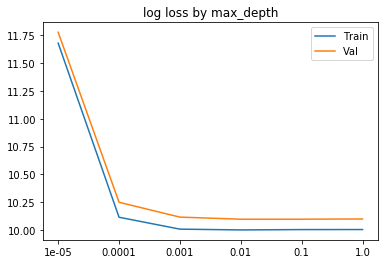

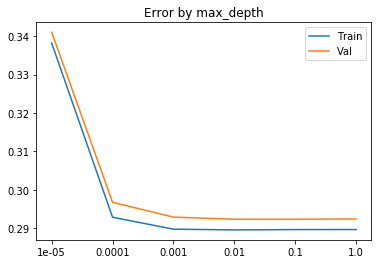

In [3]:
# Plot logloss/error by train/val and C
plt.plot([str(i) for i in c_vals],
        [log_loss(y_train,i.predict(x_train[keep_vars10])) \
        for i in m_list])
plt.plot([str(i) for i in c_vals],
        [log_loss(y_val,i.predict(x_val[keep_vars10])) \
        for i in m_list])
plt.title(label='log loss by max_depth')
plt.legend(['Train', 'Val'])
plt.show()

plt.plot([str(i) for i in c_vals],
        [1-accuracy_score(y_train,i.predict(x_train[keep_vars10])) \
        for i in m_list])
plt.plot([str(i) for i in c_vals],
        [1-accuracy_score(y_val,i.predict(x_val[keep_vars10])) \
        for i in m_list])
plt.title(label='Error by max_depth')
plt.legend(['Train', 'Val'])
plt.show()

As expected, regularization wasn't necessary (and actually resulted in worse performance). Let's take a look at the classification report for the model with no regularization.

In [4]:
print('Train')
print(confusion_matrix(y_train,m_list[5].predict(x_train[keep_vars10])))
print(classification_report(y_train,m_list[5].predict(x_train[keep_vars10])))

print('Validation')
print(confusion_matrix(y_val,m_list[5].predict(x_val[keep_vars10])))
print(classification_report(y_val,m_list[5].predict(x_val[keep_vars10])))

Train
[[123540  33892]
 [ 42933  64880]]
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76    157432
         1.0       0.66      0.60      0.63    107813

   micro avg       0.71      0.71      0.71    265245
   macro avg       0.70      0.69      0.70    265245
weighted avg       0.71      0.71      0.71    265245

Validation
[[30746  8585]
 [10804 16177]]
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76     39331
         1.0       0.65      0.60      0.63     26981

   micro avg       0.71      0.71      0.71     66312
   macro avg       0.70      0.69      0.69     66312
weighted avg       0.70      0.71      0.71     66312



Also as expected, essentially identical performance as the SVM. Like the other models I've trained, I'll run another that takes the class imbalance into account:

In [5]:
lr_bal = LogisticRegression(solver='saga',
                           class_weight={1.0:sum(y_train==0)/sum(y_train==1)})
lr_bal.fit(x_train[keep_vars10],y_train)

# Get classification report
print('Train')
print(confusion_matrix(y_train,lr_bal.predict(x_train[keep_vars10])))
print(classification_report(y_train,lr_bal.predict(x_train[keep_vars10])))

print('Validation')
print(confusion_matrix(y_val,lr_bal.predict(x_val[keep_vars10])))
print(classification_report(y_val,lr_bal.predict(x_val[keep_vars10])))

Train
[[106010  51422]
 [ 27084  80729]]
              precision    recall  f1-score   support

         0.0       0.80      0.67      0.73    157432
         1.0       0.61      0.75      0.67    107813

   micro avg       0.70      0.70      0.70    265245
   macro avg       0.70      0.71      0.70    265245
weighted avg       0.72      0.70      0.71    265245

Validation
[[26298 13033]
 [ 6815 20166]]
              precision    recall  f1-score   support

         0.0       0.79      0.67      0.73     39331
         1.0       0.61      0.75      0.67     26981

   micro avg       0.70      0.70      0.70     66312
   macro avg       0.70      0.71      0.70     66312
weighted avg       0.72      0.70      0.70     66312



Again, VERY similar performance (within .01) as the SVM model. I'll save them both for later comparison. Next up, a simple ANN.

In [6]:
pickle.dump(m_list[5], open('lr_unbal.pickle', 'wb'))
pickle.dump(lr_bal, open('lr_bal.pickle', 'wb'))